In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
cobertura = pd.read_csv('../data/01_raw/taxa_cobertura.csv', 
                        encoding='latin1', sep=';')
cobertura = cobertura.rename(columns=str.lower)

## Estatísticas Básicas de Cobertura

### 1. Existe disparidade regional de penetração?

In [3]:
cobertura['fl_regiao_metropolitana'] = cobertura['cd_rm'] != 0 & ~cobertura['cd_rm'].astype(str).str.endswith('90')
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'].str.replace(',', '.')
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'].astype(float)
cobertura['tx_cobert_assistencia_medica'] = cobertura['tx_cobert_assistencia_medica'] / 100
cobertura = cobertura[~cobertura['sg_uf'].isin(('EX', 'XX'))]

In [4]:
cobertura['fl_regiao_metropolitana'].value_counts()

False    132223
True      13468
Name: fl_regiao_metropolitana, dtype: int64

In [5]:
regioes = {
    'AC': 'N',
    'AL': 'NE',
    'AM': 'N',
    'AP': 'N',
    'BA': 'NE',
    'CE': 'NE',
    'DF': 'CO',
    'ES': 'SE',
    'GO': 'CO',
    'MA': 'NE',
    'MG': 'SE',
    'MS': 'CO',
    'MT': 'CO',
    'PA': 'N',
    'PB': 'NE',
    'PE': 'NE',
    'PI': 'NE',
    'PR': 'S',
    'RJ': 'SE',
    'RN': 'NE',
    'RO': 'N',
    'RR': 'N',
    'RS': 'S',
    'SC': 'S',
    'SE': 'NE',
    'SP': 'SE',
    'TO': 'N',
}
cobertura['regiao'] = cobertura['sg_uf'].map(regioes)

#### Penetração por Estado (UF)

In [6]:
uf = cobertura.groupby(['sg_uf', 'regiao'])[['populacao', 'benef_assistencia_medica']].sum()
uf['perc_cobert_assistencia_medica'] = (uf['benef_assistencia_medica'] / uf['populacao'])
uf['perc_cobert_assistencia_medica'] = 100 * uf['perc_cobert_assistencia_medica']
uf = uf.reset_index()

Text(0.5, 1.0, 'Penetração por UF')

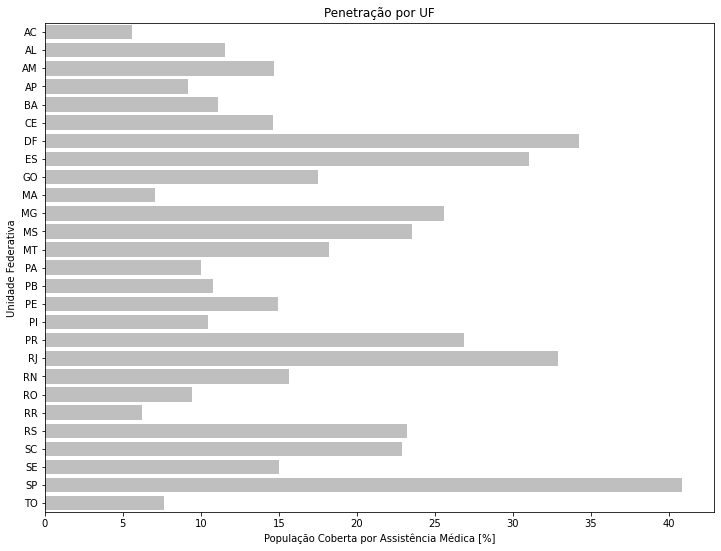

In [7]:
_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=uf, y='sg_uf', x='perc_cobert_assistencia_medica', 
            ax=ax, color='grey', alpha=0.5)
plt.xlabel('População Coberta por Assistência Médica [%]')
plt.ylabel('Unidade Federativa')
plt.title('Penetração por UF')

#### Penetração por Região

In [8]:
regiao = cobertura.groupby(['regiao'])[['populacao', 'benef_assistencia_medica']].sum()
regiao['perc_cobert_assistencia_medica'] = (regiao['benef_assistencia_medica'] / regiao['populacao'])
regiao['perc_cobert_assistencia_medica'] = 100 * regiao['perc_cobert_assistencia_medica']
regiao = regiao.reset_index()
regiao

regiao  populacao  benef_assistencia_medica  perc_cobert_assistencia_medica
0     CO   14846894                   3215503                       21.657749
1      N   16347807                   1706998                       10.441755
2     NE   53907144                   6578393                       12.203193
3      S   27841297                   6832692                       24.541572
4     SE   81565983                  28639768                       35.112392

Text(0.5, 1.0, 'Penetração por Região')

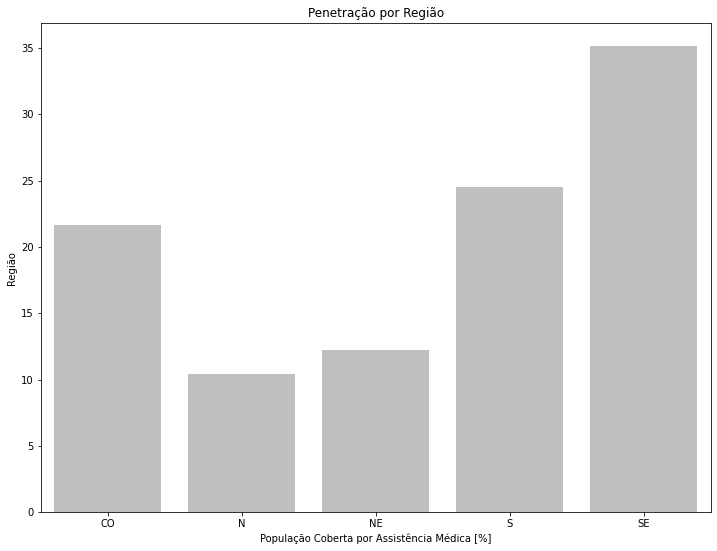

In [9]:
_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=regiao, x='regiao', y='perc_cobert_assistencia_medica', 
            ax=ax, color='grey', alpha=0.5)
plt.xlabel('População Coberta por Assistência Médica [%]')
plt.ylabel('Região')
plt.title('Penetração por Região')

### Potencial de Crescimento das Regiões
1. Assumindo que o potencial para as outras regiões é a cobertura para a região Sudeste
2. Assumindo que para os outros estados da região Sudeste o potencial de crescimento é a cobertura do estado de SP
3. Para SP, vamos assumir que o crescimento se manterá na média dos últimos anos

In [10]:
potencial = uf.copy()
cobertura_sudeste = regiao.query('regiao == "SE"')['perc_cobert_assistencia_medica'].values
cobertura_sp = uf.query('sg_uf == "SP"')['perc_cobert_assistencia_medica'].values

mask_sudeste = potencial['regiao'] == 'SE'
mask_sp = potencial['sg_uf'] == 'SP'

potencial['pot_cobert_assistencia_medica'] = cobertura_sudeste - potencial['perc_cobert_assistencia_medica']
potencial['pot_aumento_perc_cobert_assistencia_medica'] = 1 + potencial['pot_cobert_assistencia_medica'] / potencial['perc_cobert_assistencia_medica']

potencial.loc[mask_sp, 'pot_cobert_assistencia_medica'] = cobertura_sp - potencial.loc[mask_sp, 'perc_cobert_assistencia_medica']
potencial.loc[mask_sp, 'pot_aumento_perc_cobert_assistencia_medica'] = 1 + potencial.loc[mask_sp, 'pot_cobert_assistencia_medica'] / potencial.loc[mask_sp, 'perc_cobert_assistencia_medica']

potencial

sg_uf regiao  populacao  benef_assistencia_medica  \
0     AC      N     758786                     42620   
1     AL     NE    3165472                    365786   
2     AM      N    3590985                    528575   
3     AP      N     698602                     64297   
4     BA     NE   14175341                   1577792   
5     CE     NE    8606005                   1261193   
6     DF     CO    2648532                    907165   
7     ES     SE    3578067                   1110455   
8     GO     CO    6577938                   1151683   
9     MA     NE    6714314                    473290   
10    MG     SE   19855332                   5077479   
11    MS     CO    2505088                    588896   
12    MT     CO    3115336                    567759   
13    PA      N    7822205                    783361   
14    PB     NE    3815171                    411370   
15    PE     NE    8931028                   1337323   
16    PI     NE    3160748                    329827   
17    PR      S   10577755                   2842007   
18    RJ     SE   16231365                   5338202   
19    RN     NE    3228198                    504504   
20    RO      N    1590011                    150621   
21    RR      N     469524                     29257   
22    RS      S   10880256                   2528564   
23    SC      S    6383286                   1462121   
24    SE     NE    2110867                    317308   
25    SP     SE   41901219                  17113632   
26    TO      N    1417694                    108267   

    perc_cobert_assistencia_medica  pot_cobert_assistencia_medica  \
0                         5.616867                      29.495525   
1                        11.555496                      23.556896   
2                        14.719499                      20.392893   
3                         9.203667                      25.908726   
4                        11.130540                      23.981852   
5                        14.654802                      20.457590   
6                        34.251616                       0.860777   
7                        31.035053                       4.077339   
8                        17.508268                      17.604125   
9                         7.048970                      28.063422   
10                       25.572370                       9.540022   
11                       23.507997                      11.604396   
12                       18.224647                      16.887745   
13                       10.014580                      25.097812   
14                       10.782479                      24.329914   
15                       14.973898                      20.138495   
16                       10.435093                      24.677299   
17                       26.867771                       8.244621   
18                       32.888189                       2.224203   
19                       15.628038                      19.484355   
20                        9.472953                      25.639439   
21                        6.231204                      28.881188   
22                       23.239931                      11.872461   
23                       22.905460                      12.206933   
24                       15.032117                      20.080275   
25                       40.842802                       0.000000   
26                        7.636838                      27.475554   

    pot_aumento_perc_cobert_assistencia_medica  
0                                     6.251242  
1                                     3.038588  
2                                     2.385434  
3                                     3.815044  
4                                     3.154599  
5                                     2.395965  
6                                     1.025131  
7                                     1.131379  
8                                     2.005475  
9          

In [11]:
potencial.groupby('sg_uf')[['populacao']].sum()

populacao
sg_uf           
AC        758786
AL       3165472
AM       3590985
AP        698602
BA      14175341
CE       8606005
DF       2648532
ES       3578067
GO       6577938
MA       6714314
MG      19855332
MS       2505088
MT       3115336
PA       7822205
PB       3815171
PE       8931028
PI       3160748
PR      10577755
RJ      16231365
RN       3228198
RO       1590011
RR        469524
RS      10880256
SC       6383286
SE       2110867
SP      41901219
TO       1417694

### Comparação - Regiões Metropolitanas

Text(0.5, 1.0, 'Penetração por Região - Regiões Metropolitanas')

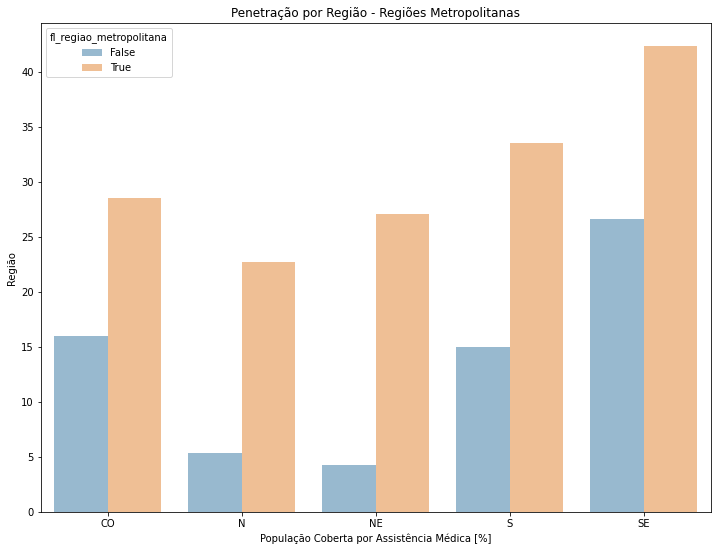

In [12]:
df = cobertura.groupby(['regiao', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=df, x='regiao', 
            y='perc_cobert_assistencia_medica', 
            hue='fl_regiao_metropolitana',
            ax=ax, alpha=0.5)
plt.xlabel('População Coberta por Assistência Médica [%]')
plt.ylabel('Região')
plt.title('Penetração por Região - Regiões Metropolitanas')

Text(0.5, 1.0, 'Penetração por UF - Regiões Metropolitanas')

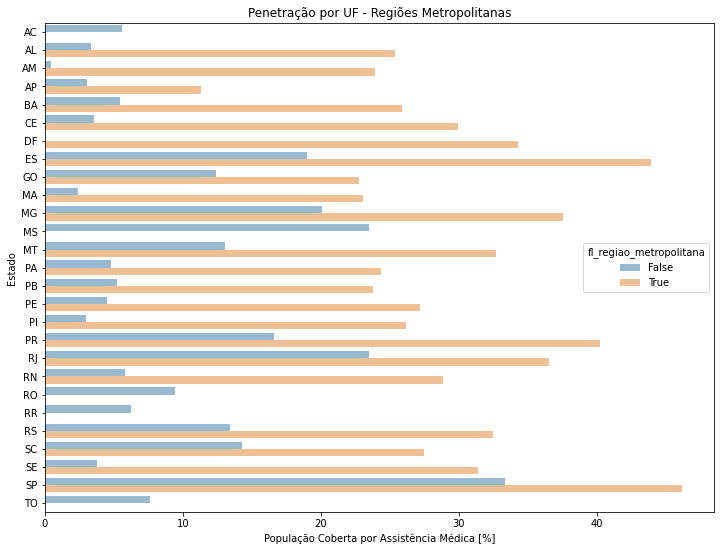

In [13]:
df = cobertura.groupby(['sg_uf', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] 
                                        / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(12, 9))
sns.barplot(data=df, y='sg_uf', x='perc_cobert_assistencia_medica', hue='fl_regiao_metropolitana',
            ax=ax, alpha=0.5)
plt.xlabel('População Coberta por Assistência Médica [%]')
plt.ylabel('Estado')
plt.title('Penetração por UF - Regiões Metropolitanas')

## Faixas Etárias

In [14]:
faixas_etarias = {
    'Até 1 ano': '01. [0, 1[',
    '1 a 4 anos': '02. [1, 4]',
    '5 a 9 anos': '03. [5, 9]',
    '10 a 14 anos': '04. [10, 14]',
    '15 a 19 anos': '05. [15, 19]',
    '20 a 29 anos': '07. [20, 29]',
    '30 a 39 anos': '08. [30, 39]',
    '40 a 49 anos': '09. [40, 49]',
    '50 a 59 anos': '10. [50, 59]',
    '60 a 69 anos': '11. [60, 69]',
    '70 a 79 anos': '12. [70, 79]',
    '80 anos ou mais': '13. [80, inf[',
}
cobertura['cat_fx_etaria'] = cobertura['faixa_etaria'].map(faixas_etarias)

Text(0.5, 1.0, 'Penetração por Faixa Etária')

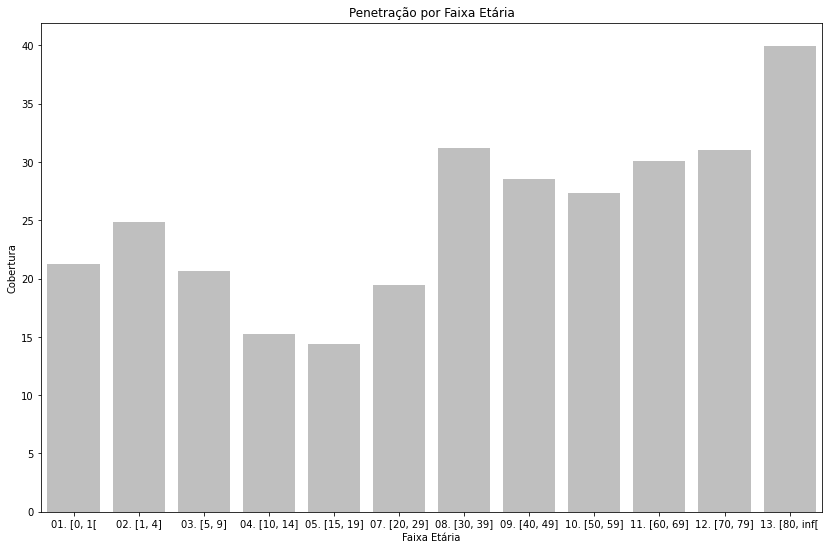

In [15]:
df = cobertura.groupby(['cat_fx_etaria'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(14, 9))
sns.barplot(data=df, x='cat_fx_etaria', 
            y='perc_cobert_assistencia_medica', 
            color='grey', ax=ax, alpha=0.5)
plt.xlabel('Faixa Etária')
plt.ylabel('Cobertura')

plt.title('Penetração por Faixa Etária')

Text(0.5, 1.0, 'Penetração por Faixa Etária - Regiões Metropolitanas')

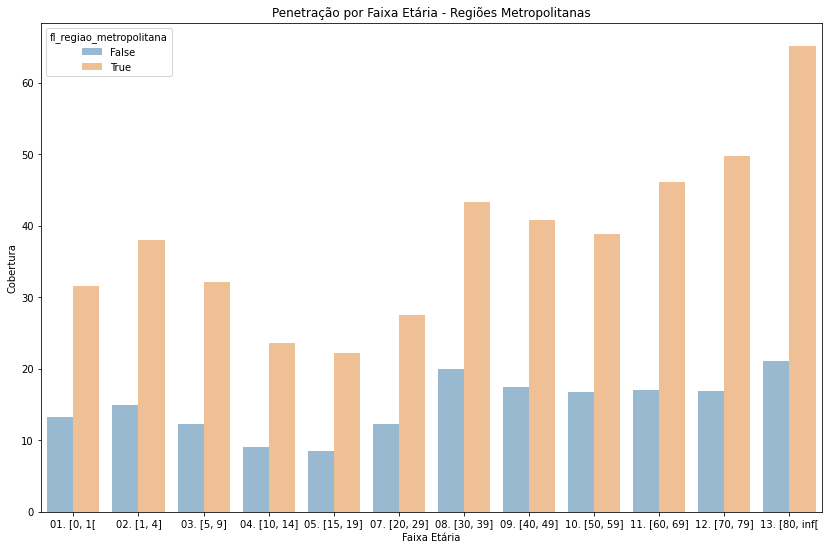

In [16]:
df = cobertura.groupby(['cat_fx_etaria', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

_, ax = plt.subplots(1, figsize=(14, 9))
sns.barplot(data=df, x='cat_fx_etaria', y='perc_cobert_assistencia_medica', hue='fl_regiao_metropolitana',
            ax=ax, alpha=0.5)
plt.xlabel('Faixa Etária')
plt.ylabel('Cobertura')
plt.title('Penetração por Faixa Etária - Regiões Metropolitanas')

Text(0.5, 0.98, 'Penetração de Assistencia Médica')

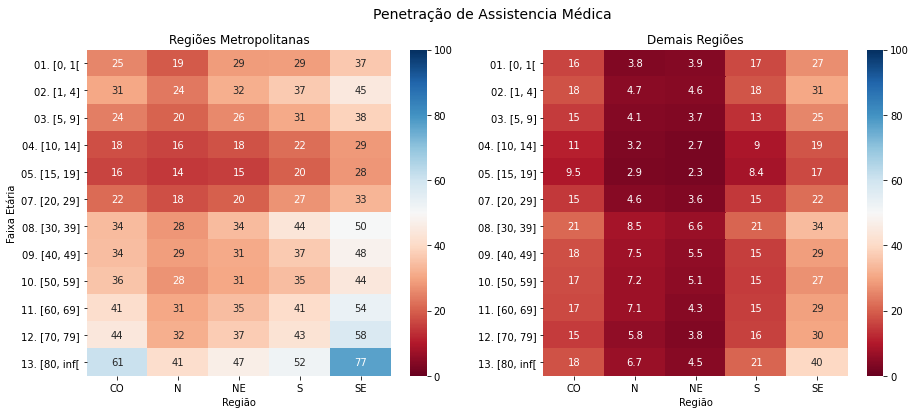

In [17]:
def plot_cobertura_bivar(data: pd.DataFrame, lines: str, columns: str, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, figsize=(12, 9))

    df = (
        data
        .groupby([lines, columns])
        [['populacao', 'benef_assistencia_medica']]
        .sum()
    )
    df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
    df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
    df = df.reset_index()
    table = pd.pivot(df, lines, columns, 'perc_cobert_assistencia_medica')

    sns.heatmap(table, vmin=0, vmax=100, cmap='RdBu', ax=ax, annot=True)

    
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
plot_cobertura_bivar(cobertura.query('fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[0])
plot_cobertura_bivar(cobertura.query('not fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[1])

axs[0].set_xlabel('Região')
axs[0].set_ylabel('Faixa Etária')
axs[0].set_title('Regiões Metropolitanas')
axs[1].set_xlabel('Região')
axs[1].set_ylabel('')
axs[1].set_title('Demais Regiões')
fig.suptitle("Penetração de Assistencia Médica", fontsize=14)

## Genero

Text(0.5, 1.0, 'Demais Regiões')

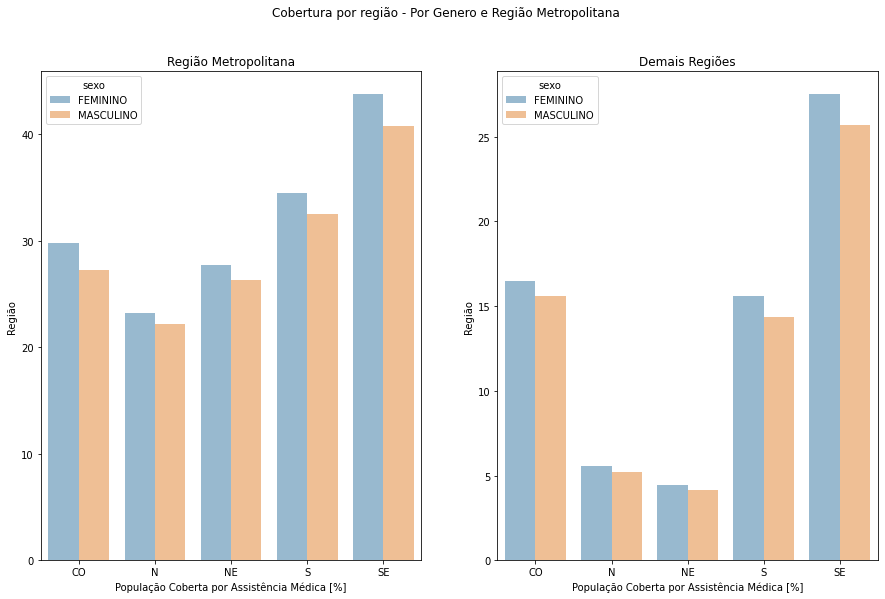

In [18]:
df = cobertura.groupby(['regiao', 'sexo', 'fl_regiao_metropolitana'])[['populacao', 'benef_assistencia_medica']].sum()
df['perc_cobert_assistencia_medica'] = (df['benef_assistencia_medica'] / df['populacao'])
df['perc_cobert_assistencia_medica'] = 100 * df['perc_cobert_assistencia_medica']
df = df.reset_index()

fig, axs = plt.subplots(1, 2, figsize=(15, 9))
fig.suptitle("Cobertura por região - Por Genero e Região Metropolitana")
sns.barplot(data=df.query('fl_regiao_metropolitana'), 
            x='regiao', 
            y='perc_cobert_assistencia_medica', 
            hue='sexo',
            ax=axs[0], alpha=0.5)
axs[0].set_xlabel('População Coberta por Assistência Médica [%]')
axs[0].set_ylabel('Região')
axs[0].set_title('Região Metropolitana')

sns.barplot(data=df.query('not fl_regiao_metropolitana'), 
            x='regiao', 
            y='perc_cobert_assistencia_medica', 
            hue='sexo',
            ax=axs[1], alpha=0.5)
axs[1].set_xlabel('População Coberta por Assistência Médica [%]')
axs[1].set_ylabel('Região')
axs[1].set_title('Demais Regiões')

Text(0.5, 1.0, 'Demais Regiões')

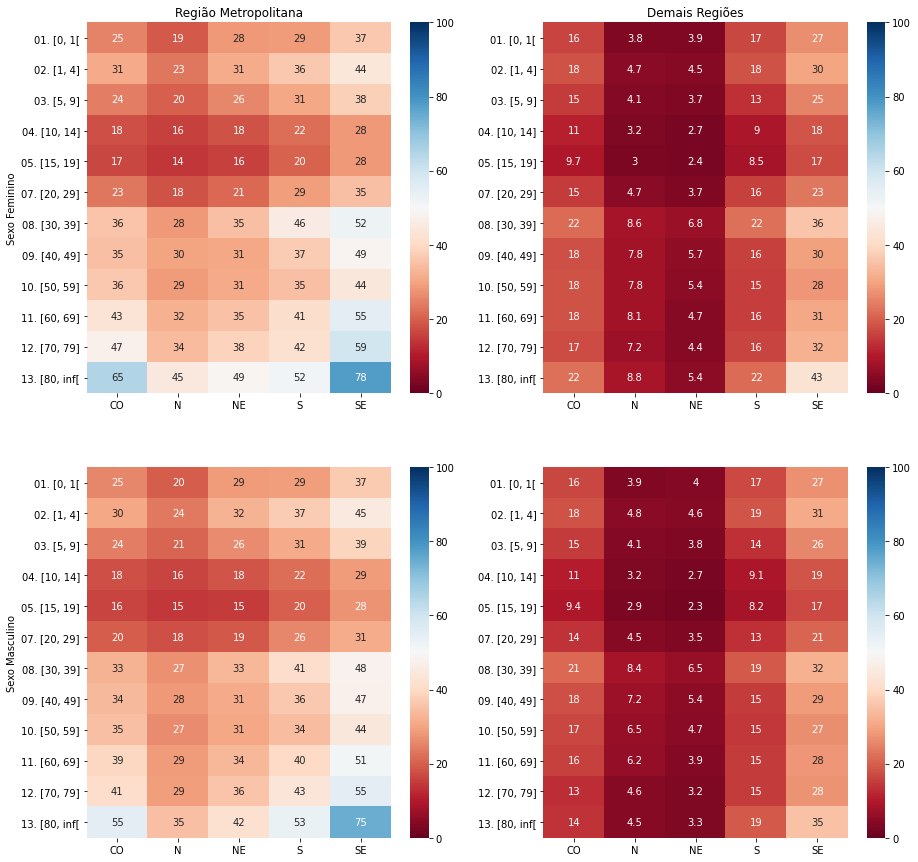

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharey='col')
plot_cobertura_bivar(cobertura.query('sexo == "FEMININO" and fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[0, 0])
plot_cobertura_bivar(cobertura.query('sexo == "FEMININO" and not fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[0, 1])
plot_cobertura_bivar(cobertura.query('sexo == "MASCULINO" and fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[1, 0])
plot_cobertura_bivar(cobertura.query('sexo == "MASCULINO" and not fl_regiao_metropolitana'), 'cat_fx_etaria', 'regiao', axs[1, 1])

for ax in axs.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    
axs[0, 0].set_ylabel('Sexo Feminino')
axs[1, 0].set_ylabel('Sexo Masculino')
axs[0, 0].set_title('Região Metropolitana')
axs[0, 1].set_title('Demais Regiões')